## Projeção Perspectiva

In [1]:
from pathlib import Path
from skimage import io, transform
import numpy as np
from numpy.linalg import solve
from matplotlib import pyplot as plt
from typing import Tuple

In [2]:
def gmt_bilinear_interpolation(
    image: np.ndarray, x_o: float, y_o: float
) -> float:
    """Apply a bilinear interpolation to a pixel of an image.

    Parameters:
        image: input image
        x_o: x coordinate of the pixel
        y_o: y coordinate of the pixel
    Returns:
        pixel: interpolated pixel
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    x_o = np.clip(x_o, 0, cols - 1)
    y_o = np.clip(y_o, 0, rows - 1)
    x_i, y_i = int(x_o), int(y_o)

    # Get the four pixels
    p1 = image[y_i, x_i]
    p2 = image[y_i, x_i + 1]
    p3 = image[y_i + 1, x_i]
    p4 = image[y_i + 1, x_i + 1]

    # Get the distances
    dx = x_o - x_i
    dy = y_o - y_i

    weights = np.array(
        [(1 - dx) * (1 - dy), dx * (1 - dy), (1 - dx) * dy, dx * dy]
    )

    neighbors = np.array([p1, p2, p3, p4])
    pixel = weights @ neighbors.T
    return pixel


def gmt_bilinear_interpolation_vet(
    image: np.ndarray, coords: np.ndarray, shape: Tuple[int, int]
) -> np.ndarray:
    """Apply a bilinear interpolation to a pixel of an image.

    Parameters:
        image: input image
        coords: coordinates of the pixel
        shape: shape of the output image
    Returns:
        image_blnr: interpolated image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    x_o, y_o = coords
    x_o = np.clip(x_o, 0, cols - 1)
    y_o = np.clip(y_o, 0, rows - 1)

    # Get the coordinates of the neighbor
    x_n = np.floor(x_o).astype(np.uint32)
    y_n = np.floor(y_o).astype(np.uint32)

    # Get the distances
    dx = x_o - x_n
    dy = y_o - y_n

    # Get the weights of the pixels
    weights = np.array(
        [(1 - dx) * (1 - dy), dx * (1 - dy), (1 - dx) * dy, dx * dy]
    )

    xn_1 = np.where(x_n + 1 < cols - 1, x_n + 1, cols - 1)
    yn_1 = np.where(y_n + 1 < rows - 1, y_n + 1, rows - 1)

    # Get the neighborhood of the pixel
    neighborhood = np.vstack(
        (
            image[y_n, x_n],
            image[y_n, xn_1],
            image[yn_1, x_n],
            image[yn_1, xn_1],
        )
    )

    image_blnr = np.sum(weights * neighborhood, axis=0)
    return image_blnr.reshape(shape).astype(image.dtype)

In [3]:
def warp_naive(
    image: np.ndarray, gmt: np.ndarray, inverse: bool = False
) -> np.ndarray:
    """Apply a geometric transformation to an image.

    Parameters:
        image: input image
        gmt: transformation matrix (3x3)
        inverse: if True, apply the inverse transformation
    Returns:
        t_image: transformed image
    """

    t_image = np.zeros_like(image)

    # (x_i, y_i, w) = transform * (x_o, y_o, 1)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Get the coordinates of the transformed pixel
            coords = gmt @ np.array([x, y, 1])

            # Normalize the coordinates (x, y, w) -> (x/w, y/w, 1)
            x_t, y_t, _ = coords / coords[2]

            # Check if the pixel is inside the image
            inside = (
                (x_t >= 0)
                & (y_t >= 0)
                & (x_t < image.shape[1])
                & (y_t < image.shape[0])
            )
            if not inside:
                continue

            # Get the pixel value
            # print(int(round(x_t)), int(round(y_t)))
            if inverse:
                # t_image[y, x] = image[int(y_t), int(x_t)]
                t_image[y, x] = gmt_bilinear_interpolation(image, x_t, y_t)
            else:
                # t_image[int(y_t), int(x_t)] = image[y, x]
                t_image[int(y_t), int(x_t)] = gmt_bilinear_interpolation(
                    image, x, y
                )

    return t_image


def warp_vet(
    image: np.ndarray, gmt: np.ndarray, inverse: bool = False
) -> np.ndarray:
    """Apply a geometric transformation to an image.
    (Vectorized version)
    Parameters:
        image: input image
        gmt: transformation matrix (3x3)
        inverse: if True, apply the inverse transformation
    Returns:
        t_image: transformed image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    indeces = np.indices((rows, cols))
    # coord = (x, y, 1)
    coords = np.vstack(
        (
            indeces[1].ravel(),
            indeces[0].ravel(),
            np.ones(rows * cols, dtype=np.int32),
        )
    )

    # Apply the transformation
    t_coords = gmt @ coords
    t_coords = t_coords[:2] / t_coords[2]
    # t_coords = np.round(t_coords[:2] / t_coords[2]).astype(np.int32)

    # Create the transformed image
    t_image = np.zeros_like(image)
    # Check if the pixel is inside the image
    if inverse:
        t_image = gmt_bilinear_interpolation_vet(image, t_coords, image.shape)
    else:
        t_coords = np.round(t_coords).astype(np.int32)
        inside = (
            (t_coords[0] >= 0)
            & (t_coords[1] >= 0)
            & (t_coords[0] < cols)
            & (t_coords[1] < rows)
        )
        t_image[t_coords[1][inside], t_coords[0][inside]] = image[
            coords[1][inside], coords[0][inside]
        ]

    return t_image

### Perspective Transform

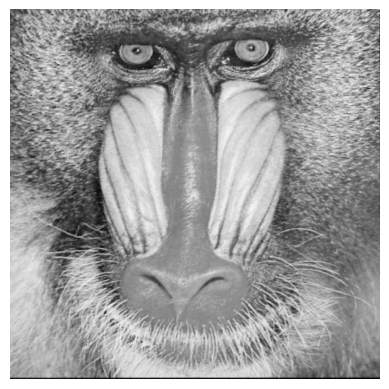

In [4]:
# Path to the images
images_path = Path('images')

# Read the images
image = io.imread(images_path / 'baboon_perspectiva.png')
image = image[:, :, 0]

# Define os pontos de origem e destino
dst = np.array([[0, 0], [511, 0], [511, 511], [0, 511]])
src = np.array([[37, 51], [342, 42], [485, 467], [73, 380]])

# Cria a matriz de coeficientes do sistema de equações
A = np.zeros((8, 8))
for i in range(4):
    A[i * 2, :] = [
        src[i, 0],
        src[i, 1],
        1,
        0,
        0,
        0,
        -dst[i, 0] * src[i, 0],
        -dst[i, 0] * src[i, 1],
    ]
    A[i * 2 + 1, :] = [
        0,
        0,
        0,
        src[i, 0],
        src[i, 1],
        1,
        -dst[i, 1] * src[i, 0],
        -dst[i, 1] * src[i, 1],
    ]

# Cria o vetor de soluções do sistema de equações
b = np.zeros((8,))
for i in range(4):
    b[i * 2] = dst[i, 0]
    b[i * 2 + 1] = dst[i, 1]

# Resolve o sistema de equações
h = solve(A, b)

# Cria a matriz de projeção perspectiva
H = np.zeros((3, 3))
H[0, :] = h[:3]
H[1, :] = h[3:6]
H[2, :2] = h[6:]
H[2, 2] = 1

# Aplicar a transformação perspectiva usando a função do skimage
# tform = transform.ProjectiveTransform()
# tform.estimate(src, dst)
# image_transformed_1 = transform.warp(image, tform)


# Mostrar as imagens
# plt.imshow(image_transformed_1, cmap='gray')
# plt.axis('off')
# plt.show()

# image_transformed_2 = warp_naive(image, H, inverse=True)
# plt.imshow(image_transformed_2, cmap='gray')
# plt.axis('off')
# plt.show()
H = np.linalg.inv(H)
image_transformed_3 = warp_vet(image, H, inverse=True)
plt.imshow(image_transformed_3, cmap='gray')
plt.axis('off')
plt.show()

### Others

In [5]:
from typing import Tuple


def gmt_coords(
    rows: int, cols: int, gmt: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Get the coordinates to apply a geometric transformation to an image.

    Parameters:
        rows: number of rows of the image
        cols: number of columns of the image
        gmt: transformation matrix (3x3)
    Returns:
        tuple:
            coords: coordinates of the transformed pixels
            t_coords: transformed coordinates
    """

    # Get the coordinates of the pixels
    indeces = np.indices((rows, cols))
    # coord = (x, y, 1)
    coords = np.vstack(
        (
            indeces[1].ravel(),
            indeces[0].ravel(),
            np.ones(rows * cols, dtype=np.int32),
        )
    )

    # Apply the transformation
    t_coords = gmt @ coords

    # Normalize the coordinates
    t_coords = t_coords[:2] / t_coords[2]

    # Return the coordinates of the pixels (x, y)
    return coords[:2], t_coords


def gmt_bilinear_interpolation(
    image: np.ndarray, coords: np.ndarray, shape: Tuple[int, int]
) -> np.ndarray:
    """Apply a bilinear interpolation to a pixel of an image.

    Parameters:
        image: input image
        coords: coordinates of the pixel
        shape: shape of the output image
    Returns:
        image_blnr: interpolated image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    x_o, y_o = coords
    x_o = np.clip(x_o, 0, cols - 1)
    y_o = np.clip(y_o, 0, rows - 1)

    # Get the coordinates of the neighbor
    x_n = np.floor(x_o).astype(np.uint32)
    y_n = np.floor(y_o).astype(np.uint32)

    # Get the distances
    dx = x_o - x_n
    dy = y_o - y_n

    # Get the weights of the pixels
    weights = np.array(
        [(1 - dx) * (1 - dy), dx * (1 - dy), (1 - dx) * dy, dx * dy]
    )

    xn_1 = np.where(x_n + 1 < cols - 1, x_n + 1, cols - 1)
    yn_1 = np.where(y_n + 1 < rows - 1, y_n + 1, rows - 1)

    # xn_1 = x_n + 1
    # yn_1 = y_n + 1

    # padded_image = np.pad(image, ((1, 1), (1, 1)), mode='edge')

    # Get the neighborhood of the pixel
    neighborhood = np.vstack(
        (
            image[y_n, x_n],
            image[y_n, xn_1],
            image[yn_1, x_n],
            image[yn_1, xn_1],
        )
    )

    image_blnr = np.sum(weights * neighborhood, axis=0)
    return image_blnr.reshape(shape).astype(image.dtype)

In [6]:
def gmt_nearest_neighbor_interpolation(
    image: np.ndarray, coords: np.ndarray, shape: Tuple[int, int]
) -> np.ndarray:
    """Apply a nearest neighbor interpolation to a pixel of an image.

    Parameters:
        image: input image
        coords: coordinates of the pixel
        shape: shape of the output image
    Returns:
        image_blnr: interpolated image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    x_o, y_o = coords
    x_o = np.clip(x_o, 0, cols - 1)
    y_o = np.clip(y_o, 0, rows - 1)

    # Get the coordinates of the neighbor
    x_n = np.round(x_o).astype(np.uint32)
    y_n = np.round(y_o).astype(np.uint32)

    image_blnr = image[y_n, x_n]
    return image_blnr.reshape(shape).astype(image.dtype)

In [8]:
def gmt_lagrange_interpolation(
    image: np.ndarray, coords: np.ndarray, shape: np.ndarray
) -> np.ndarray:
    """Compute lagrange interpolation

    Params:
        image: Input image
        coords: Coordinates of output image
        shape: Shape of output image
    Returns:
        out: Output image
    """

    # Compute the indices of the pixels
    rows, cols = image.shape
    x, y = coords
    x = np.clip(x, 0, cols - 1)
    y = np.clip(y, 0, rows - 1)
    x0 = np.floor(x).astype(np.uint32)
    y0 = np.floor(y).astype(np.uint32)

    # Compute the fractional part of the coordinates
    dx = x - x0
    dy = y - y0

    # Compute L interpolation weights
    L_w = np.array(
        [
            -dx * (dx - 1) * (dx - 2) / 6,
            (dx + 1) * (dx - 1) * (dx - 2) / 2,
            -dx * (dx + 1) * (dx - 2) / 2,
            dx * (dx + 1) * (dx - 1) / 6,
        ]
    )

    # Compute interpolation weights
    w = np.array(
        [
            -dy * (dy - 1) * (dy - 2) / 6,
            (dy + 1) * (dy - 1) * (dy - 2) / 2,
            -dy * (dy + 1) * (dy - 2) / 2,
            dy * (dy + 1) * (dy - 1) / 6,
        ]
    )

    # Pad the image
    padded_image = np.pad(image, ((2, 2), (2, 2)), mode='constant')

    # Compute the interpolated pixels
    pixels = np.array(
        [
            padded_image[y0 + n, x0 + 2 + i]
            for n in range(1, 5)
            for i in range(-1, 3)
        ]
    )

    # Compute the Lagrange interpolation
    L = np.array(
        [np.sum(L_w * pixels[n * 4 : (n + 1) * 4], axis=0) for n in range(4)]
    )

    # Compute the output image
    out = np.sum(w * L, axis=0).reshape(shape).astype(image.dtype)

    return out

#### Teste

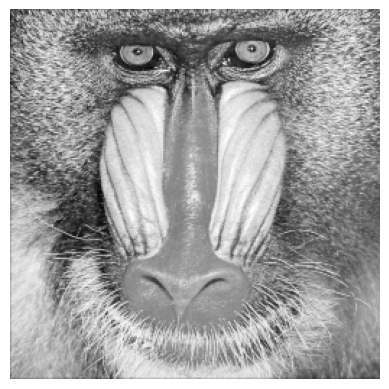

In [9]:
images_path = Path('images')
image = io.imread(images_path / 'baboon.png')

sx, sy = 0.5, 0.5
S_inv = np.array([[1 / sx, 0, 0], [0, 1 / sy, 0], [0, 0, 1]])
row, col = image.shape
new_row, new_col = row, col
new_row, new_col = int(row * sy), int(col * sx)
coords, t_coords = gmt_coords(new_row, new_col, S_inv)
t_image_bc = gmt_bicubic_interpolation(image, t_coords, (new_row, new_col))
# t_image_bl = gmt_nearest_neighbor_interpolation(image, t_coords, (new_row, new_col))
# t_image_bl = bicubic_interpolation(image, t_coords[0], t_coords[1])
# t_image_bl = warp_naive(image, S_inv, inverse=True)
# plot the image
plt.imshow(t_image_bc, cmap='gray')
plt.axis('off')
plt.show()

#### Test 2

In [58]:
image = io.imread(images_path / 'baboon.png')

row, col = image.shape
sx, sy = 2, 2

S_inv = np.array([[1 / sx, 0, 0], [0, 1 / sy, 0], [0, 0, 1]])

S = np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]])

# Apply the transformation
new_row, new_col = int(row * sy), int(col * sx)
coords, t_coords = gmt_coords(new_row, new_col, S_inv)

t_image_nnb = gmt_nearest_neighbor_interpolation(image, t_coords, (new_row, new_col))
t_image_bl = gmt_bilinear_interpolation(image, t_coords, (new_row, new_col))
t_image_lgg = gmt_lagrange_interpolation(image, t_coords, (new_row, new_col))

In [59]:
def gmt_bicubic_interpolation(
    image: np.ndarray, coords: np.ndarray, shape: np.ndarray
) -> np.ndarray:
    """Compute bicubic interpolation using B-splines

    Params:
        image: Input image
        coords: Coordinates of output image
        shape: Shape of output image
    Returns:
        out: Output image
    """

    def R(s: np.ndarray) -> np.ndarray:
        """R Cubic B-spline function

        Params:
            s: Input array
        Returns:
            R: R function values
        """

        R = (
            np.power(np.maximum(s + 2, 0), 3)
            - 4 * np.power(np.maximum(s + 1, 0), 3)
            + 6 * np.power(np.maximum(s, 0), 3)
            - 4 * np.power(np.maximum(s - 1, 0), 3)
        ) / 6

        return R

    # Compute the indices of the pixels
    rows, cols = image.shape
    x, y = coords
    x = np.clip(x, 0, cols - 1)
    y = np.clip(y, 0, rows - 1)
    x0 = np.floor(x).astype(np.uint32)
    y0 = np.floor(y).astype(np.uint32)

    # Compute the fractional part of the coordinates
    dx = x - x0
    dy = y - y0

    # Compute interpolation weights
    weights = np.array(
        [R(m - dx)*R(dy - n) for m in range(-1, 3) for n in range(-1, 3)]
    )


    # Pad the image
    padded_image = np.pad(image, ((2, 2), (2, 2)), mode='edge')

    # Compute the interpolated pixels
    pixels = np.array(
        [
            padded_image[y0 + n + 2, x0 + m + 2]
            for n in range(-1, 3)
            for m in range(-1, 3)
        ]
    )

    # Compute the output image
    out = np.sum(weights * pixels, axis=0).reshape(shape).astype(image.dtype)
    return out

In [53]:
A = np.arange(0, 4).reshape(2, 2)

row, col = A.shape
sx, sy = 1, 1

S_inv = np.array([[1 / sx, 0, 0], [0, 1 / sy, 0], [0, 0, 1]])

coords, t_coords = gmt_coords(row*sx, row*sy, S_inv)

A_bc = gmt_bicubic_interpolation(A, t_coords, (row*sx, row*sy))

print(A)
print(A_bc)

dx, dy:
[0. 0. 0. 0.] [0. 0. 0. 0.]
weights:
(16, 4)
[0.02777778 0.02777778 0.02777778 0.02777778]
[0.11111111 0.11111111 0.11111111 0.11111111]
pixels:
[[0 0 0 0]
 [0 1 0 1]
 [1 1 1 1]
 [1 1 1 1]
 [0 0 2 2]
 [0 1 2 3]
 [1 1 3 3]
 [1 1 3 3]
 [2 2 2 2]
 [2 3 2 3]
 [3 3 3 3]
 [3 3 3 3]
 [2 2 2 2]
 [2 3 2 3]
 [3 3 3 3]
 [3 3 3 3]]
[[0 1]
 [2 3]]
[[0 1]
 [1 2]]


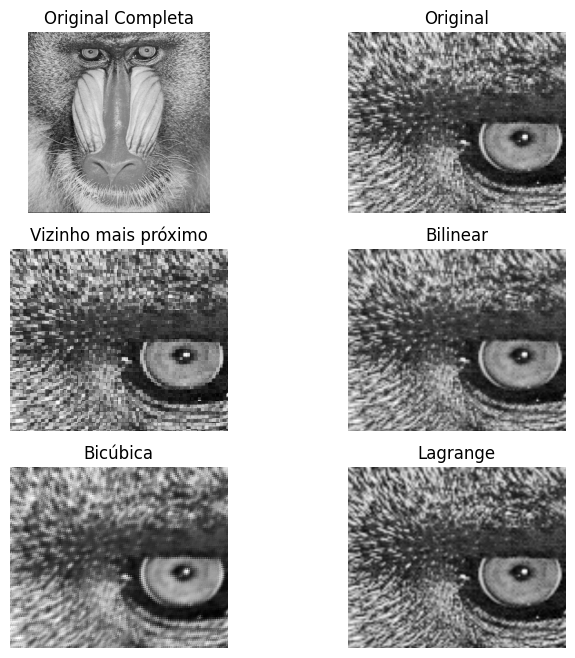

In [60]:
t_image_bcb = gmt_bicubic_interpolation(image, t_coords, (new_row, new_col))

# Show the 5 images
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].set_title('Original Completa')
axs[0, 0].axis('off')

axs[0, 1].imshow(image[:100,80:200], cmap='gray')
axs[0, 1].set_title('Original')
axs[0, 1].axis('off')

axs[1, 0].imshow(t_image_nnb[:200,160:400], cmap='gray')
axs[1, 0].set_title('Vizinho mais próximo')
axs[1, 0].axis('off')

axs[1, 1].imshow(t_image_bl[:200,160:400], cmap='gray')
axs[1, 1].set_title('Bilinear')
axs[1, 1].axis('off')

axs[2, 0].imshow(t_image_bcb[:200,160:400], cmap='gray')
axs[2, 0].set_title('Bicúbica')
axs[2, 0].axis('off')

axs[2, 1].imshow(t_image_lgg[:200,160:400], cmap='gray')
axs[2, 1].set_title('Lagrange')
axs[2, 1].axis('off')

plt.show()


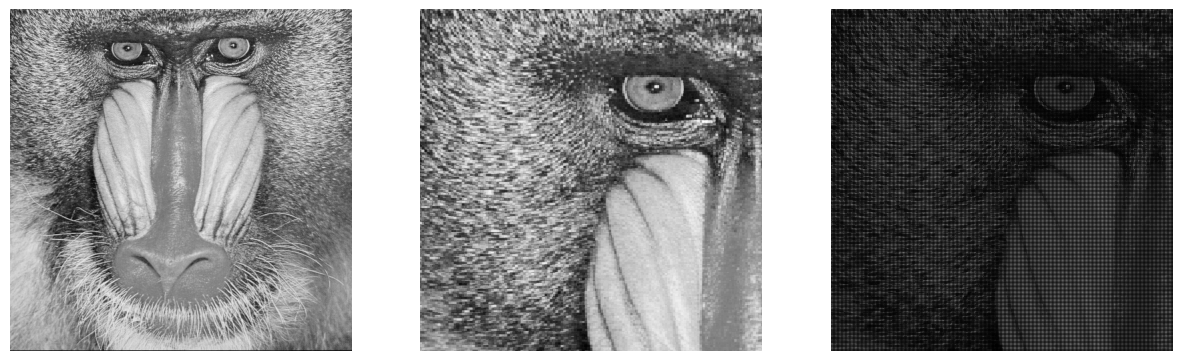

In [9]:
h, w = image.shape[:2]

h_t, w_t = 2 * h, 2 * w

sx, sy = w_t / w, h_t / h

S_inv = np.array([[1 / sx, 0, 0], [0, 1 / sy, 0], [0, 0, 1]])

S = np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]])

# Apply the transformation
t_image = warp_vet(image, S_inv, inverse=True)
t_image_2 = warp_vet(image, S, inverse=False)

# Plot the 3 images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(t_image, cmap='gray')
ax[1].axis('off')
ax[2].imshow(t_image_2, cmap='gray')
ax[2].axis('off')
plt.show()

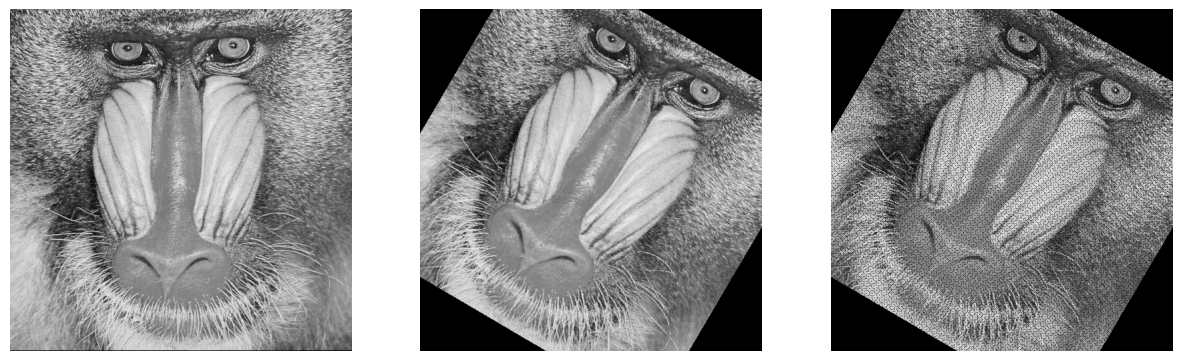

In [5]:
# Define the rotation matrix
theta = 30.433
R = np.array(
    [
        [np.cos(np.deg2rad(theta)), -np.sin(np.deg2rad(theta)), 0],
        [np.sin(np.deg2rad(theta)), np.cos(np.deg2rad(theta)), 0],
        [0, 0, 1],
    ]
)

R_inv = R.T

# Encontre o ponto central da imagem
h, w = image.shape[:2]
cx, cy = w // 2, h // 2

# Transle o ponto central para a origem
T1 = np.array([[1, 0, -cx], [0, 1, -cy], [0, 0, 1]])

M = np.linalg.inv(T1) @ R @ T1

M_inv = np.linalg.inv(M)

# Apply the transformation
t_image = warp_vet(image, M_inv, inverse=True)
t_image_2 = warp_vet(image, M, inverse=False)

# Plot the 3 images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(t_image, cmap='gray')
ax[1].axis('off')
ax[2].imshow(t_image_2, cmap='gray')
ax[2].axis('off')
plt.show()

## 2 Transformações Geométricas

### Bibliotecas

In [5]:
from pathlib import Path
import numpy as np
from skimage import transform, io
from matplotlib import pyplot as plt

### Funções Auxiliares

In [6]:
def open_image(image_path: Path) -> np.ndarray:
    """Abre uma imagem binária e retorna uma matriz numpy.
    Parâmetros:
        image_path: caminho para a imagem
    Retorno:
        Imagem como uma matriz numpy.
    """
    image = io.imread(image_path)
    assert (
        len(image.shape) == 2
    ), f'A Imagem {image_path.name} tem mais de 1 canal'
    # returns a binary version of the image
    return image


def two_images(
    original: np.ndarray,
    processed: np.ndarray,
    t1: str,
    t2: str,
    path: Path = None,
):
    """Visualizar a imagem original versus o resultado do processamento.
    Parâmetros:
        original: imagem original
        processed: imagem processada
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
    fig.tight_layout(pad=0.5)

    axs[0].imshow(original, cmap='gray')
    axs[1].imshow(processed, cmap='gray')

    axs[0].set_title(f'(a) {t1}')
    axs[1].set_title(f'(b) {t2}')

    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

    if path:
        fig.savefig(path, bbox_inches='tight', pad_inches=0.1)


def histogram(img: np.ndarray, bins: int = 256) -> np.ndarray:
    """Calcula o histograma de uma imagem.
    Parâmetros:
        img: imagem
        bins: número de bins
    """
    return np.histogram(img, bins=bins)[0]


def black_percentual(histogram: np.ndarray) -> float:
    """Calcula o percentual de pixels pretos em uma imagem.
    Parâmetros:
        histogram: histograma da imagem
    Retorno:
        Percentual de pixels pretos.
    """
    return np.round(histogram[0] / histogram.sum(), 4) * 100


def img_and_histogram(
    img: np.ndarray, hist: np.ndarray, title: str, path: Path = None
):
    """Visualizar a imagem e seu histograma.
    Parâmetros:
        img: imagem
        hist: histograma
    """
    fig, axs = plt.subplots(
        nrows=1, ncols=2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]}
    )
    plt.suptitle(title)

    # Image
    axs[0].set_title('(a) Imagem')
    axs[0].imshow(img, cmap='gray')
    axs[0].axis('off')

    # Histogram
    axs[1].set_title('(b) Histograma')
    bins_range = range(hist.shape[0])
    if hist.shape[0] == 2:
        percents = [black_percentual(hist), 100 - black_percentual(hist)]
        bar = axs[1].bar(
            bins_range,
            percents,
            width=1,
            align='center',
            edgecolor='black',
            color='#006AF4',
        )
        axs[1].set_xticks([0, 1], ['preto', 'branco'])
        axs[1].axes.yaxis.set_visible(False)
        axs[1].spines['right'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        black_per = f'{percents[0]:.2f}%'
        axs[1].text(
            bar[0].get_x() + bar[0].get_width() / 2,
            bar[0].get_height(),
            black_per,
            ha='center',
            va='bottom',
            fontsize=12,
        )
        white_per = f'{percents[1]:.2f}%'
        axs[1].text(
            bar[1].get_x() + bar[1].get_width() / 2,
            bar[1].get_height(),
            white_per,
            ha='center',
            va='bottom',
            fontsize=12,
        )
    else:
        axs[1].bar(bins_range, hist, color='#006AF4')
        text = f'preto: {black_percentual(hist):.2f}%'
        axs[1].text(
            0.2,
            0.9,
            text,
            transform=axs[1].transAxes,
            color='black',
            fontsize=14,
        )

    plt.show()

    # Save figure
    if path:
        fig.savefig(path, bbox_inches='tight', pad_inches=0.1)


def image_properties(image: np.ndarray):
    """Imprime as propriedades da imagem.
    Parâmetros:
        image: imagem
    """
    print('Propriedades da imagem:')
    print(f'Dimensões: {image.shape}')
    print(f'Tipo de dados: {image.dtype}')
    print(f'Mínimo: {image.min()}')
    print(f'Máximo: {image.max()}')

### Abrir a imagem original

In [7]:
images_path = Path('images')
image = open_image(images_path / 'baboon.png')
image_properties(image)

Propriedades da imagem:
Dimensões: (512, 512)
Tipo de dados: uint8
Mínimo: 0
Máximo: 230


### Transformações Geométricas

#### Rotação

[724. 724.]


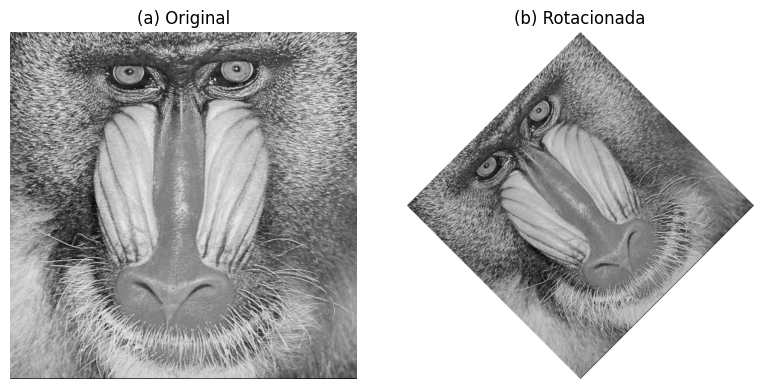

Propriedades da imagem:
Dimensões: (724, 724)
Tipo de dados: float64
Mínimo: 0.0
Máximo: 1.0


In [8]:
# Definir angulo de rotação
angle = 45
# Definir o centro de rotação
center = (0, 0)
center = None
mode = ['constant', 'edge', 'symmetric', 'reflect', 'wrap']
# Rotacionar a imagem
image_rotated = transform.rotate(
    image, angle, resize=True, center=center, order=3, mode='constant', cval=1
)

# Visualizar a imagem original e a rotacionada
two_images(image, image_rotated, 'Original', 'Rotacionada')

# propriedades da imagem rotacionada
image_properties(image_rotated)

#### Escala (Fator de escala)

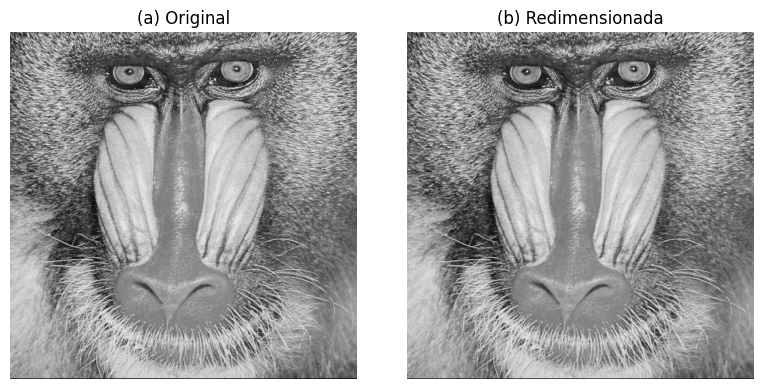

Propriedades da imagem:
Dimensões: (1024, 1024)
Tipo de dados: float64
Mínimo: 0.0
Máximo: 0.9019607843137255


In [78]:
# Definir o fator de escala
scale = 2

# Redimensionar a imagem
image_resized = transform.rescale(
    image, scale, order=3, anti_aliasing=False, mode='constant', cval=1
)

# Visualizar a imagem original e a redimensionada
two_images(image, image_resized, 'Original', 'Redimensionada')

# propriedades da imagem redimensionada
image_properties(image_resized)

#### Escala (Altura, Largura)

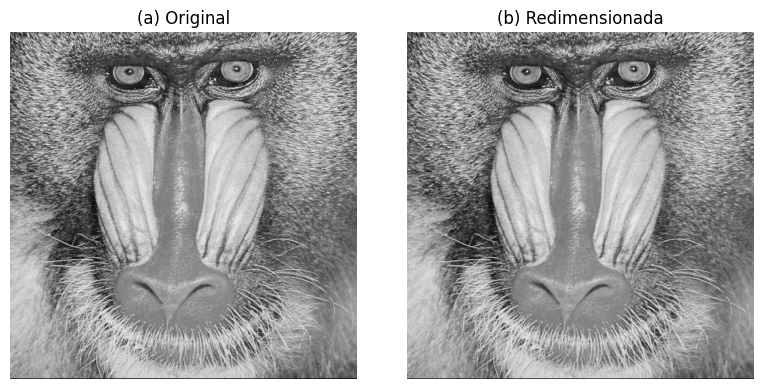

Propriedades da imagem:
Dimensões: (1024, 1024)
Tipo de dados: float64
Mínimo: 0.0
Máximo: 0.9019607843137255


In [84]:
# Definir altura e largura
height, width = 1024, 1024

# Redimensionar a imagem
image_resized = transform.resize(
    image,
    (height, width),
    order=3,
    anti_aliasing=False,
    mode='constant',
    cval=1,
)

# Visualizar a imagem original e a redimensionada
two_images(image, image_resized, 'Original', 'Redimensionada')

# propriedades da imagem redimensionada
image_properties(image_resized)